<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - ISCTE <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>

<font size="3"> Afonso Fareleiro - Armando Ferreira - Tomás Carvalho </font>
  
<font size="3"> Group 12 - 'MU' Micron Technology, Inc 

# RL for algorithmic trading

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
import quantstats as qs

# High-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [7]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
mu_data = mu.history(start="2019-01-01", end="2023-09-30")

mu_data.info()
mu_data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1195 entries, 2019-01-02 00:00:00-05:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1195 non-null   float64
 1   High          1195 non-null   float64
 2   Low           1195 non-null   float64
 3   Close         1195 non-null   float64
 4   Volume        1195 non-null   int64  
 5   Dividends     1195 non-null   float64
 6   Stock Splits  1195 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 74.7 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-25 00:00:00-04:00,68.176264,69.074767,67.497396,68.465782,14900000,0.0,0.0
2023-09-26 00:00:00-04:00,67.856800,68.935003,67.477428,67.826851,12752500,0.0,0.0
2023-09-27 00:00:00-04:00,68.006551,68.735331,66.638830,68.096397,20852300,0.0,0.0
2023-09-28 00:00:00-04:00,65.860130,66.978259,63.723694,65.091408,46749800,0.0,0.0
2023-09-29 00:00:00-04:00,66.249478,68.615533,66.249478,67.916695,24307500,0.0,0.0


<Axes: xlabel='Date'>

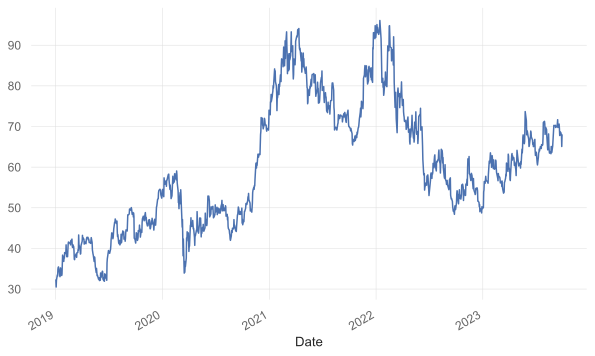

In [8]:
# Daily close price data for MU
mu_data.Close.plot()

## 2. Calculate returns, expected mean returns and risk

In [9]:
# Asset Returns/Rate of Returns: the cumulative daily rate of return is useful to determine /
#                                   the value of an investment at regular intervals.
data_close = mu_data[['Close']]
data_close.columns = ['MU']

returns = np.log(data_close / data_close.shift(1))
returns = returns.dropna()

# Expected Mean Returns
mean_returns = returns.mean()

# Volatility: market volatility is defined as the standard deviation of prices/returns.
vol = returns.std()

# Gain-Loss Ratio (GLR) represents the relative relationship of trades with a positive /
#                                       return and trades with a negative return
glr = returns[returns['MU'] > 0].sum() / returns[returns['MU'] < 0].sum().abs()

# Sharpe Ratio (SR) is the amount of excess return over the risk-free rate as the relevant measure of risk.
## rf is daily risk free rate.
# rf = (1.02 ** (1 / 360)) - 1

risk_free_rate = 0
sr = (mean_returns - risk_free_rate) / vol

# Compound Annual Growth Rate (CAGR)
cumulative_returns = returns.cumsum()
num_trading_days = len(returns)
cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1

# Variance
var = returns.var() * 252

# CVAR
cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

# See metrics in table format
data_summary = pd.DataFrame({
    'Mean Returns': mean_returns,
    'Volatility': vol,
    'Gain-Loss Ratio (GLR)': glr,
    'Sharpe Ratio (SR)': sr,
    'CAGR': cagr,
    'Variance': var,
    'CVAR': cvar
})

data_summary


C:\Users\Admin\AppData\Local\Temp\ipykernel_11876\1702605445.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1


,Mean Returns,Volatility,Gain-Loss Ratio (GLR),Sharpe Ratio (SR),CAGR,Variance,CVAR
MU,0.000624,0.029188,1.059818,0.02138,-0.060209,0.214685,-16.058258


## 3. Define statistical trading strategy (at least one, maximum 2)

In [63]:
# Exponential moving average (EMA) strategy
def ema_strategy(data, small, large):
    # Define your trading strategy based on the historical data
    # Example: Buy when the 20-day moving average is above the 100-day moving average, sell otherwise
    signals = pd.DataFrame(data)

    # EMA for 20 and 100-day windows
    signals['ema_short'] = signals['Close'].ewm(span = small, adjust = False).mean()
    signals['ema_long'] = signals['Close'].ewm(span = large, adjust = False).mean()
                         
    # Define a crossover strategy
    signals['bullish'] = 0.0
    signals['bullish'] = np.where(signals['ema_short'] > signals['ema_long'], 1, 0)
    signals['crossover'] = signals['bullish'].diff()

    # Calculate passive and strategy's returns
    signals['returns'] = np.log(signals['Close'] / signals['Close'].shift(1))
    signals['strategy'] = signals['bullish'].shift(1) * signals['returns']
    
    return signals

C:\Users\Admin\AppData\Local\Temp\ipykernel_11876\3328235721.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')
C:\Users\Admin\AppData\Local\Temp\ipykernel_11876\3328235721.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')


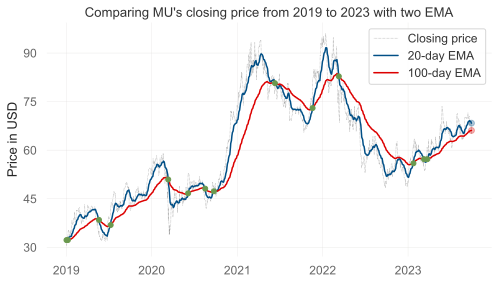

In [64]:
# Initiate strategy
ema_strat = ema_strategy(mu_data, 20, 100)

# Plot exponential moving averages for our strategy
# fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ema_strat['Close'], label='Closing price', color='grey', linestyle=':', linewidth=0.5)
ax.plot(ema_strat['ema_short'], label='20-day EMA', color='#014f86')
ax.plot(ema_strat.index[-1], ema_strat['ema_short'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#014f86')
ax.plot(ema_strat['ema_long'], label='100-day EMA', color='#DC0000')
ax.plot(ema_strat.index[-1], ema_strat['ema_long'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#DC0000')

# Plot crossovers
idx = np.argwhere(ema_strat['crossover']).flatten()
ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')

# Add Legend and Labels
ax.legend(loc='best')

# Prettify

## Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

## Reformat y-axis
ax.set_ylabel('Price in USD')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

## Remove the spines
ax.spines[['top','right','bottom']].set_visible(False)

## Make the left spine thicker
ax.spines['left'].set_linewidth(1.1)
# Add in title and subtitle
ax.set_title(label="Comparing MU's closing price from 2019 to 2023 with two EMA")
## Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Show the plot
plt.show()


<Axes: title={'center': 'Strategy Positioning'}, xlabel='Date'>

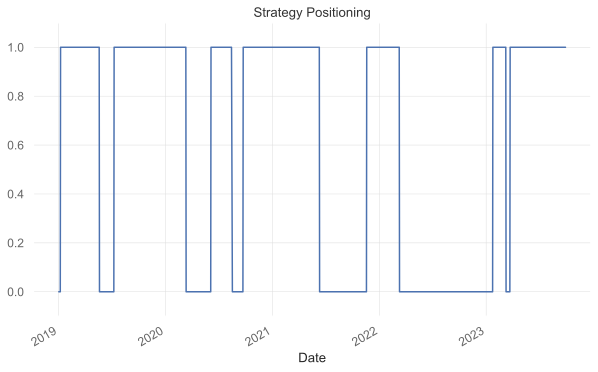

In [65]:
# Plot our strategy's positions
ema_strat['bullish'].plot(ylim=[-0.1, 1.1],
title='Strategy Positioning',
figsize=(10, 6))

returns     187.767570
strategy     29.788791
dtype: float64

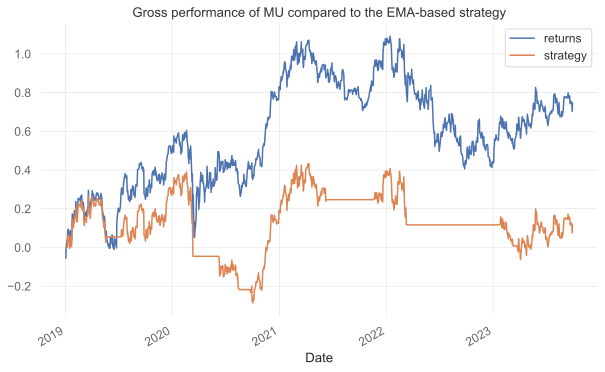

In [66]:
# Plot our strategy's returns compared to MU's stock performance
ema_strat[['returns', 'strategy']].cumsum().plot(figsize=(10, 6), 
                                                         title="Gross performance of MU compared to the EMA-based strategy")

ema_strat[['returns', 'strategy']].sum() * 252

## 4. Evaluate the efficacy of the trading strategy

In [67]:
qs.reports.metrics(ema_strat['strategy'])

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-29
Risk-Free Rate      0.0%
Time in Market      61.0%

Cumulative Return   -14.63%
CAGR﹪              -2.28%

Sharpe              0.07
Prob. Sharpe Ratio  56.32%
Sortino             0.1
Sortino/√2          0.07
Omega               1.02

Max Drawdown        -51.57%
Longest DD Days     1318

Gain/Pain Ratio     0.02
Gain/Pain (1M)      0.08

Payoff Ratio        0.98
Profit Factor       1.02
Common Sense Ratio  1.01
CPC Index           0.51
Tail Ratio          0.99
Outlier Win Ratio   6.5
Outlier Loss Ratio  2.64

MTD                 -3.04%
3M                  0.22%
6M                  11.14%
YTD                 -4.11%
1Y                  -4.11%
3Y (ann.)           4.68%
5Y (ann.)           -2.28%
10Y (ann.)          -2.28%
All-time (ann.)     -2.28%

Avg. Drawdown       -12.18%
Avg. Drawdown Days  170
Recovery Factor     0.23
Ulcer Index         0.29
Serenity Index      

## 5. Training a Deep Q-learning model in stock trading

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Short: 0>}


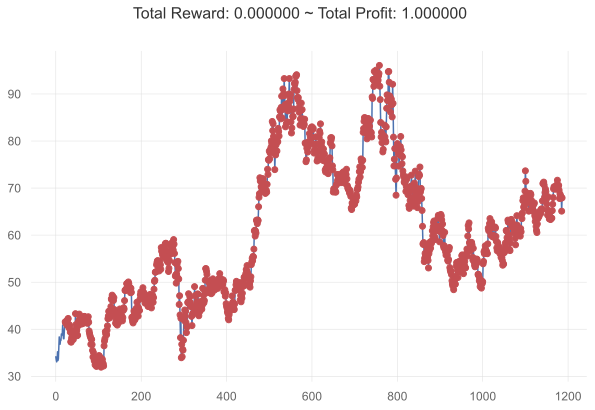

In [68]:
from gym_anytrading.envs import StocksEnv, Actions, Positions
from stable_baselines3 import DQN

# Create a gym_anytrading environment using MU's stock data
env = gym.make('stocks-v0',
    df = mu_data,
    window_size=22,
    # frame_bound=(50, 100),
)

# Create a DQN model and set parameters
model = DQN("MlpPolicy",
            env,
            batch_size = 4, 
            learning_rate= 0.01,
            gamma= 0.85,
            verbose = 1,
            learning_starts = 100
            )

# Initiate learning and save finished model as zip file
model.learn(total_timesteps=1000, log_interval=4)

# Reset environment to its initial state
observation, info = env.reset(seed=2023)

# Loop to apply the trained model on the environment
while True:
    action = model.predict(observation, deterministic=True)
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

# Save learned model
# model.save("dqn_mu")
# Load saved model (zip file)
#model = DQN.load("dqn_mu")

## 6. Evaluate the efficacy of the RL strategy

In [69]:
# Calculate metrics and visualize plots for the DeepQ-Learning strategy
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1164])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.metrics(rl_returns)

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-08-16
Risk-Free Rate      0.0%
Time in Market      0.0%

Cumulative Return   0.0%
CAGR﹪              0.0%

Sharpe              -
Prob. Sharpe Ratio  -
Sortino             -
Sortino/√2          -
Omega               -

Max Drawdown        %
Longest DD Days     -

Gain/Pain Ratio     -
Gain/Pain (1M)      -

Payoff Ratio        -
Profit Factor       -
Common Sense Ratio  -
CPC Index           -
Tail Ratio          -
Outlier Win Ratio   -
Outlier Loss Ratio  -

MTD                 0.0%
3M                  0.0%
6M                  0.0%
YTD                 0.0%
1Y                  0.0%
3Y (ann.)           0.0%
5Y (ann.)           0.0%
10Y (ann.)          0.0%
All-time (ann.)     0.0%

Recovery Factor     -
Ulcer Index         0.0
Serenity Index      -
Avg. Drawdown Days  -


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


## 7. Fine-tune your algorithms

### 7.1. Optimizing the Exponential Moving Averages parameters

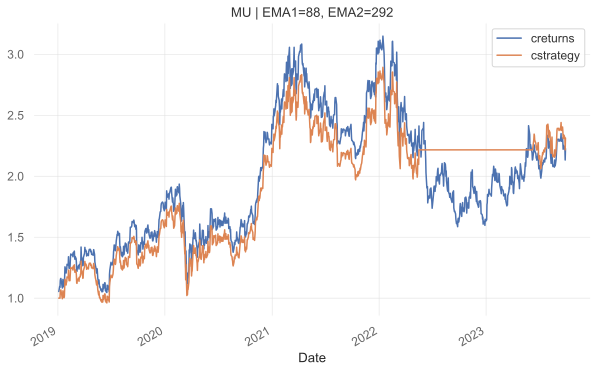

In [78]:
# Optimizing EMA strategy
import ema
ema_opt = ema.EMA('MU', 40, 20, "2019-01-01", "2023-09-30")

ema_opt.optimize_parameters((10, 100, 2), (100, 400, 2))

ema_opt.plot_results()

### 7.2. Hyperparameter tuning for RL strategy

In [ ]:
'''Your code here'''

'Your code here'

## 8. Compare and interpret the results

### 8.1. Compare between non-optimized and optimized EMA strategy

In [ ]:
# Normal EMA
ema_norm = ema_strat['strategy'].tz_localize(None)
# Optimized EMA
ema_optz = ema_strategy(mu_data, 88, 292)
ema_optz = ema_optz['strategy'].tz_localize(None)

qs.reports.metrics(ema_optz, ema_norm)

### 8.2. Compare between optimized EMA strategy and optimized RL strategy

In [ ]:
# Comparison metrics and plots between EMA
qs.extend_pandas()

# Extracting series from RL algortihm
net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1164])
rl_returns = net_worth.pct_change().iloc[1:]
rl_returns.tz_localize
rl_returns = rl_returns.tz_localize(None)

#qs.reports.metrics(rl_returns, ema_optz)